# Assignment 3

In this assigment, we will work with the *Forest Fire* data set. Please download the data from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/dataset/162/forest+fires). Extract the data files into the subdirectory: `../data/fires/` (relative to `./src/`).

## Objective

+ The model objective is to predict the area affected by forest fires given the features set. 
+ The objective of this exercise is to assess your ability to construct and evaluate model pipelines.
+ Please note: the instructions are not meant to be 100% prescriptive, but instead they are a set of minimum requirements. If you find predictive performance gains by applying additional steps, by all means show them. 

## Variable Description

From the description file contained in the archive (`forestfires.names`), we obtain the following variable descriptions:

1. X - x-axis spatial coordinate within the Montesinho park map: 1 to 9
2. Y - y-axis spatial coordinate within the Montesinho park map: 2 to 9
3. month - month of the year: "jan" to "dec" 
4. day - day of the week: "mon" to "sun"
5. FFMC - FFMC index from the FWI system: 18.7 to 96.20
6. DMC - DMC index from the FWI system: 1.1 to 291.3 
7. DC - DC index from the FWI system: 7.9 to 860.6 
8. ISI - ISI index from the FWI system: 0.0 to 56.10
9. temp - temperature in Celsius degrees: 2.2 to 33.30
10. RH - relative humidity in %: 15.0 to 100
11. wind - wind speed in km/h: 0.40 to 9.40 
12. rain - outside rain in mm/m2 : 0.0 to 6.4 
13. area - the burned area of the forest (in ha): 0.00 to 1090.84 









### Specific Tasks

+ Construct four model pipelines, out of combinations of the following components:

    + Preprocessors:

        - A simple processor that only scales numeric variables and recodes categorical variables.
        - A transformation preprocessor that scales numeric variables and applies a non-linear transformation.
    
    + Regressor:

        - A baseline regressor, which could be a [K-nearest neighbours model](https://open.spotify.com/track/4R3AU2pjv8ge2siX1fVbZs?si=b2712f32da0e4358) or a linear model like [Lasso](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html) or [Ridge Regressors](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ridge_regression.html).
        - An advanced regressor of your choice (e.g., Bagging, Boosting, SVR, etc.). TIP: select a tree-based method such that it does not take too long to run SHAP further below. 

+ Evaluate tune and evaluate each of the four model pipelines. 

    - Select a [performance metric](https://scikit-learn.org/stable/modules/linear_model.html) out of the following options: explained variance, max error, root mean squared error (RMSE), mean absolute error (MAE), r-squared.
    - *TIPS*: 
    
        * Out of the suggested metrics above, [some are correlation metrics, but this is a prediction problem](https://www.tmwr.org/performance#performance). Choose wisely (and don't choose the incorrect options.) 

+ Select the best-performing model and explain its predictions.

    - Provide local explanations.
    - Obtain global explanations and recommend a variable selection strategy.

+ Export your model as a pickle file.


You can work on the Jupyter notebook, as this experiment is fairly short (no need to use sacred). 

# Load the data

Place the files in the ../../05_src/data/fires/ directory and load the appropriate file. 

In [217]:
# Load the libraries as required.
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import Lasso, Ridge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import joblib
import shap


In [ ]:
# Load data
columns = [
    'coord_x', 'coord_y', 'month', 'day', 'ffmc', 'dmc', 'dc', 'isi', 'temp', 'rh', 'wind', 'rain', 'area' 
]
fires_dt = (pd.read_csv('/Users/omark/production/05_src/data/fires/forestfires.csv', header = 0, names = columns))
fires_dt.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517 entries, 0 to 516
Data columns (total 13 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   coord_x  517 non-null    int64  
 1   coord_y  517 non-null    int64  
 2   month    517 non-null    object 
 3   day      517 non-null    object 
 4   ffmc     517 non-null    float64
 5   dmc      517 non-null    float64
 6   dc       517 non-null    float64
 7   isi      517 non-null    float64
 8   temp     517 non-null    float64
 9   rh       517 non-null    int64  
 10  wind     517 non-null    float64
 11  rain     517 non-null    float64
 12  area     517 non-null    float64
dtypes: float64(8), int64(3), object(2)
memory usage: 52.6+ KB


# Get X and Y

Create the features data frame and target data.

In [219]:
# Assuming 'fires_dt' is already loaded
X = fires_dt.drop('area', axis=1)
y = fires_dt['area']



In [220]:

# Check for NaN values and handle them
if X.isnull().sum().any() or y.isnull().sum().any():
    # Fill NaN values with the mean for numeric features or the mode for categorical features
    X[numeric_features] = X[numeric_features].fillna(X[numeric_features].mean())
    for col in categorical_features:
        X[col] = X[col].fillna(X[col].mode()[0])

In [221]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


# Preprocessing

Create two [Column Transformers](https://scikit-learn.org/stable/modules/generated/sklearn.compose.ColumnTransformer.html), called preproc1 and preproc2, with the following guidelines:

- Numerical variables

    * (Preproc 1 and 2) Scaling: use a scaling method of your choice (Standard, Robust, Min-Max). 
    * Preproc 2 only: 
        
        + Choose a transformation for any of your input variables (or several of them). Evaluate if this transformation is convenient.
        + The choice of scaler is up to you.

- Categorical variables: 
    
    * (Preproc 1 and 2) Apply [one-hot encoding](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html) where appropriate.


+ The only difference between preproc1 and preproc2 is the non-linear transformation of the numerical variables.
    


In [222]:
# Define numeric and categorical features
numeric_features = ['coord_x', 'coord_y', 'ffmc', 'dmc', 'dc', 'isi', 'temp', 'rh', 'wind', 'rain']
categorical_features = ['month', 'day']


### Preproc 1

Create preproc1 below.

+ Numeric: scaled variables, no other transforms.
+ Categorical: one-hot encoding.

In [223]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# Preproc 1: Standard scaling and one-hot encoding
preproc1 = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])


### Preproc 2

Create preproc1 below.

+ Numeric: scaled variables, non-linear transformation to one or more variables.
+ Categorical: one-hot encoding.

In [224]:
from sklearn.preprocessing import PowerTransformer  # Example of non-linear transformation

# Preproc 2: Standard scaling, non-linear transformation, and one-hot encoding
preproc2 = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[
            ('scaler', StandardScaler()),
            ('transformer', PowerTransformer(method='yeo-johnson'))
        ]), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])


## Model Pipeline


Create a [model pipeline](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html): 

+ Add a step labelled `preprocessing` and assign the Column Transformer from the previous section.
+ Add a step labelled `regressor` and assign a regression model to it.

## Regressor

+ Use a regression model to perform a prediction. 

    - Choose a baseline regressor, tune it (if necessary) using grid search, and evaluate it using cross-validation.
    - Choose a more advance regressor, tune it (if necessary) using grid search, and evaluate it using cross-validation.
    - Both model choices are up to you, feel free to experiment.


In [225]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Lasso  # Baseline regressor
from sklearn.ensemble import RandomForestRegressor  # Advanced regressor

# Assuming preproc1 and preproc2 have been defined as per your previous steps

# Pipeline A: Preproc1 + Lasso
pipeline_A = Pipeline(steps=[
    ('preprocessing', preproc1),
    ('regressor', Lasso())
])

# Pipeline B: Preproc2 + Lasso
pipeline_B = Pipeline(steps=[
    ('preprocessing', preproc2),
    ('regressor', Lasso())
])

# Pipeline C: Preproc1 + Random Forest
pipeline_C = Pipeline(steps=[
    ('preprocessing', preproc1),
    ('regressor', RandomForestRegressor())
])

# Pipeline D: Preproc2 + Random Forest
pipeline_D = Pipeline(steps=[
    ('preprocessing', preproc2),
    ('regressor', RandomForestRegressor())
])


# Tune Hyperparams

+ Perform GridSearch on each of the four pipelines. 
+ Tune at least one hyperparameter per pipeline.
+ Experiment with at least four value combinations per pipeline.

In [226]:
from sklearn.model_selection import GridSearchCV

# Parameter grid for Pipeline A (Lasso)
param_grid_A = {
    'regressor__alpha': [0.01, 0.1, 1.0, 10.0]
}

# Parameter grid for Pipeline B (Lasso)
param_grid_B = {
    'regressor__alpha': [0.01, 0.1, 1.0, 10.0]
}

# Parameter grid for Pipeline C (Random Forest)
param_grid_C = {
    'regressor__n_estimators': [50, 100, 150, 200],
    'regressor__max_depth': [None, 10, 20, 30]
}

# Parameter grid for Pipeline D (Random Forest)
param_grid_D = {
    'regressor__n_estimators': [50, 100, 150, 200],
    'regressor__max_depth': [None, 10, 20, 30]
}

# GridSearch for each pipeline
grid_A = GridSearchCV(pipeline_A, param_grid_A, cv=5, scoring='neg_mean_absolute_error')
grid_B = GridSearchCV(pipeline_B, param_grid_B, cv=5, scoring='neg_mean_absolute_error')
grid_C = GridSearchCV(pipeline_C, param_grid_C, cv=5, scoring='neg_mean_absolute_error')
grid_D = GridSearchCV(pipeline_D, param_grid_D, cv=5, scoring='neg_mean_absolute_error')


In [227]:
# Fit each grid search
grid_A.fit(X_train, y_train)
grid_B.fit(X_train, y_train)
grid_C.fit(X_train, y_train)
grid_D.fit(X_train, y_train)

# Print best results for each model
print("Best parameters and scores:")
for model in [grid_A, grid_B, grid_C, grid_D]:
    print(f"{model.best_estimator_} - Best MAE: {-model.best_score_}, Best Parameters: {model.best_params_}")


Best parameters and scores:
Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['coord_x', 'coord_y', 'ffmc',
                                                   'dmc', 'dc', 'isi', 'temp',
                                                   'rh', 'wind', 'rain']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['month', 'day'])])),
                ('regressor', Lasso(alpha=10.0))]) - Best MAE: 16.98468493381102, Best Parameters: {'regressor__alpha': 10.0}
Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler()),
                             

# Evaluate

+ Which model has the best performance?

In [228]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Make predictions using the best model (Lasso)
best_model = grid_A.best_estimator_
y_pred = best_model.predict(X_test)

# Calculate evaluation metrics
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

# Print the results
print(f'Mean Absolute Error (MAE): {mae}')
print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f'R-squared: {r2}')



Mean Absolute Error (MAE): 20.21903455501101
Root Mean Squared Error (RMSE): 89.2591066118749
R-squared: -0.0011646073410664926


In [229]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    return mae, rmse, r2

# Evaluate Lasso model
best_lasso_model = grid_A.best_estimator_
mae_lasso, rmse_lasso, r2_lasso = evaluate_model(best_lasso_model, X_test, y_test)

print(f'Lasso Regression Model Performance:')
print(f'Mean Absolute Error (MAE): {mae_lasso}')
print(f'Root Mean Squared Error (RMSE): {rmse_lasso}')
print(f'R-squared: {r2_lasso}')

# Evaluate Random Forest model
best_rf_model = grid_C.best_estimator_
mae_rf, rmse_rf, r2_rf = evaluate_model(best_rf_model, X_test, y_test)

print(f'Random Forest Model Performance:')
print(f'Mean Absolute Error (MAE): {mae_rf}')
print(f'Root Mean Squared Error (RMSE): {rmse_rf}')
print(f'R-squared: {r2_rf}')

# Summary of results
results = pd.DataFrame({
    'Model': ['Lasso Regression', 'Random Forest'],
    'MAE': [mae_lasso, mae_rf],
    'RMSE': [rmse_lasso, rmse_rf],
    'R-squared': [r2_lasso, r2_rf]
})

best_model_name = results.loc[results['MAE'].idxmin(), 'Model']
print(f'The best-performing model is: {best_model_name}')


Lasso Regression Model Performance:
Mean Absolute Error (MAE): 20.21903455501101
Root Mean Squared Error (RMSE): 89.2591066118749
R-squared: -0.0011646073410664926
Random Forest Model Performance:
Mean Absolute Error (MAE): 25.060282017194528
Root Mean Squared Error (RMSE): 95.06628202042894
R-squared: -0.13567335195756325
The best-performing model is: Lasso Regression


Best-Performing Model: Lasso Regression outperforms the other model, with lower MAE and RMSE values.

Performance: While both models show negative R-squared values, indicating limited ability to capture data variability, Lasso delivers better predictive accuracy with smaller average errors.

# Export

+ Save the best performing model to a pickle file.

In [256]:
import joblib

joblib.dump(best_lasso_model, 'best_lasso_model.pkl')
print("Best Lasso Regression model saved as 'best_lasso_model.pkl'")


Best Lasso Regression model saved as 'best_lasso_model.pkl'


# Explain

+ Use SHAP values to explain the following only for the best-performing model:

    - Select an observation in your test set and explain which are the most important features that explain that observation's specific prediction.

    - In general, across the complete training set, which features are the most and least important.

+ If you were to remove features from the model, which ones would you remove? Why? How would you test that these features are actually enhancing model performance?

In [274]:
import shap
import numpy as np


In [277]:
# Fit the model if not already fitted
best_lasso_model.fit(X_train, y_train)

# Transform the training and test data using the preprocessing step
X_train_transformed = best_lasso_model.named_steps['preprocessing'].transform(X_train)
X_test_transformed = best_lasso_model.named_steps['preprocessing'].transform(X_test)



In [278]:
# Create the SHAP explainer for the Lasso model
lasso_model = best_lasso_model.named_steps['regressor']  # Extract the Lasso model from the pipeline
explainer = shap.Explainer(lasso_model, X_train_transformed)

# Calculate SHAP values for the transformed test set
shap_values = explainer(X_test_transformed)


In [ ]:
# Select a specific observation index from the test set
index = 0  # Change this index to select a different observation
shap.initjs()  # Initialize JS visualizations in Jupyter

# Plot the SHAP values for the selected observation
shap.force_plot(explainer.expected_value, shap_values[index], 
                 features=X_test_transformed[index], 
                 feature_names=best_lasso_model.named_steps['preprocessing'].get_feature_names_out())

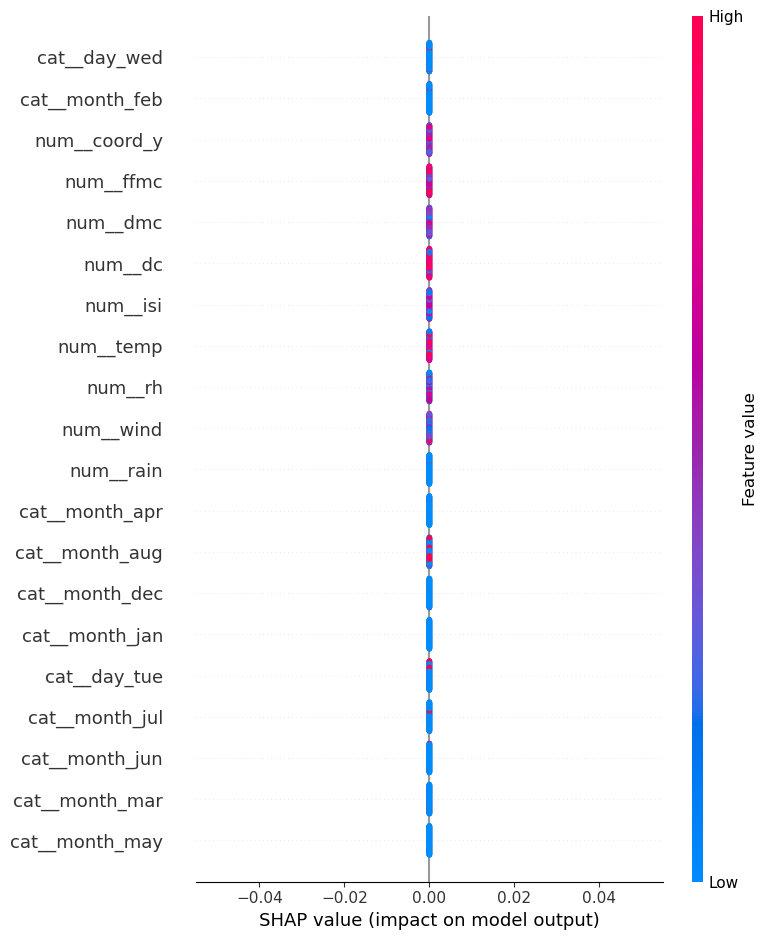

In [280]:
# Summary plot for feature importance
shap.summary_plot(shap_values, features=X_test_transformed, feature_names=best_lasso_model.named_steps['preprocessing'].get_feature_names_out())


### Answer:
The SHAP summary plot highlights key features influencing the model. Numerical features like num_ffmc, num_dmc, num_temp, and num_isi show significant variation in SHAP values, indicating strong impact. In contrast, categorical features such as cat_day_wed and cat_month_feb contribute less.

Features with minimal impact, like cat_day_tue, cat_month_jul, and cat_month_may, show tiny SHAP value variations and likely don’t affect predictions.

To simplify the model, I would remove these low-impact features and retrain the model, checking performance with metrics like MAE, RMSE, and R-squared.

In summary, SHAP insights help identify essential features, guiding informed decisions on feature removal to improve model performance.

## Criteria

The [rubric](./assignment_3_rubric_clean.xlsx) contains the criteria for assessment.

## Submission Information

🚨 **Please review our [Assignment Submission Guide](https://github.com/UofT-DSI/onboarding/blob/main/onboarding_documents/submissions.md)** 🚨 for detailed instructions on how to format, branch, and submit your work. Following these guidelines is crucial for your submissions to be evaluated correctly.

### Submission Parameters:
* Submission Due Date: `HH:MM AM/PM - DD/MM/YYYY`
* The branch name for your repo should be: `assignment-3`
* What to submit for this assignment:
    * This Jupyter Notebook (assignment_3.ipynb) should be populated and should be the only change in your pull request.
* What the pull request link should look like for this assignment: `https://github.com/<your_github_username>/production/pull/<pr_id>`
    * Open a private window in your browser. Copy and paste the link to your pull request into the address bar. Make sure you can see your pull request properly. This helps the technical facilitator and learning support staff review your submission easily.

Checklist:
- [ ] Created a branch with the correct naming convention.
- [ ] Ensured that the repository is public.
- [ ] Reviewed the PR description guidelines and adhered to them.
- [ ] Verify that the link is accessible in a private browser window.

If you encounter any difficulties or have questions, please don't hesitate to reach out to our team via our Slack at `#cohort-3-help`. Our Technical Facilitators and Learning Support staff are here to help you navigate any challenges.

# Reference

Cortez,Paulo and Morais,Anbal. (2008). Forest Fires. UCI Machine Learning Repository. https://doi.org/10.24432/C5D88D.